In [4]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import glob
from collections import Counter, defaultdict

In [2]:
directory = "" # Your path to raw data here
graph_files = glob.glob(os.path.join(directory, "graph_*.pickle"))
graphs = {}
for file in graph_files:
    with open(file, "rb") as f:
        G = pickle.load(f)
        if isinstance(G, nx.Graph):  
            graphs[file] = G
        else:
            print(f"Warning: {file} is not a valid NetworkX graph.")

print(f"Loaded {len(graphs)} graphs successfully!")

Loaded 1033 graphs successfully!


In [5]:
# Start by printing some stats about the dataset
#
# number of nodes, number of edges
# density -> 2*|E|/(|V|*(|V|-1))
# degrees

graph_stats = []
for name, G in graphs.items():
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    degrees = [d for _, d in G.degree()]
    
    graph_stats.append({
        "graph_name": name,
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "density": density,
        "avg_degree": np.mean(degrees) if degrees else 0,
        "median_degree": np.median(degrees) if degrees else 0,
        "max_degree": max(degrees) if degrees else 0
    })

df_stats = pd.DataFrame(graph_stats)
df_stats.describe()

,num_nodes,num_edges,density,avg_degree,median_degree,max_degree
count,1033.0,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000
mean,361.0,3040.826718,0.023398,16.846685,5.883833,423.887706
std,0.0,90.188627,0.000694,0.499660,0.320580,3.265834
min,361.0,2755.000000,0.021199,15.263158,5.000000,414.000000
25%,361.0,2979.000000,0.022922,16.504155,6.000000,422.000000
50%,361.0,3043.000000,0.023415,16.858726,6.000000,424.000000
75%,361.0,3102.000000,0.023869,17.185596,6.000000,426.000000
max,361.0,3288.000000,0.025300,18.216066,6.000000,437.000000


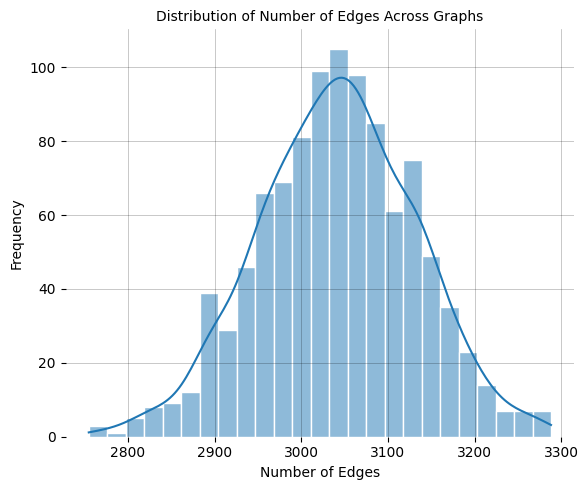

In [245]:
# Distribution of edges count accross graphs

def plot_num_edges_distribution(df_stats, 
                                bins=25, 
                                xlabel="Number of Edges", 
                                ylabel="Frequency", 
                                title="Distribution of Number of Edges Across Graphs"):
    
    """
    Plot the distribution of the number of edges in graphs.
    """
    
    plt.figure(figsize=(6, 5))
    ax = sns.histplot(df_stats["num_edges"], bins=bins, kde=True, alpha=.5, edgecolor="white")
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.title(title, fontsize=10)
    plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
    plt.box(False)
    plt.savefig('EDA/edgecount_distribution.jpeg', 
                dpi=400, 
                bbox_inches='tight', 
                transparent=True)
    plt.tight_layout()
    plt.show()


plot_num_edges_distribution(df_stats)

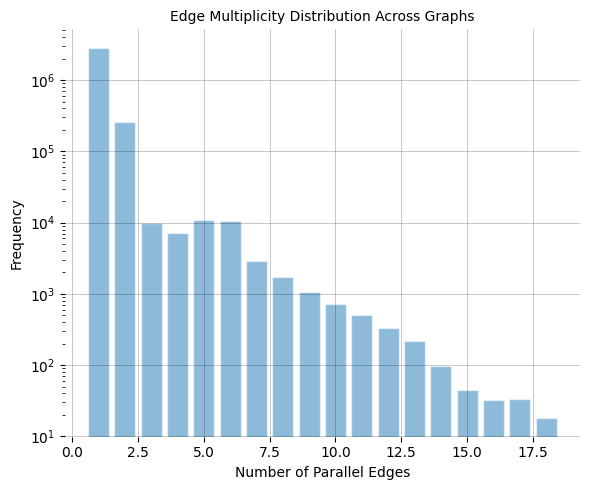

In [246]:
def plot_edge_multiplicity_distribution(graphs, 
                                        xlabel="Number of Parallel Edges", 
                                        ylabel="Frequency", 
                                        title="Edge Multiplicity Distribution Across Graphs"):
    """
    Plot the distribution of edge multiplicities (parallel edges) across graphs.
    """

    edge_multiplicities = []
    for G in graphs.values():
        for u, v, data in G.edges(data=True):
            edge_multiplicities.append(G.number_of_edges(u, v))  # Count multiple edges

    multiplicity_counts = Counter(edge_multiplicities)
    plt.figure(figsize=(6, 5))
    plt.bar(multiplicity_counts.keys(), multiplicity_counts.values(), edgecolor="white", alpha=0.5)
    plt.yscale("log")
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.title(title, fontsize=10)
    plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
    plt.box(False)
    plt.savefig('EDA/edge_multiplicity_distribution.jpeg', dpi=400, bbox_inches='tight', transparent=True)
    plt.tight_layout()
    plt.show()

plot_edge_multiplicity_distribution(graphs)

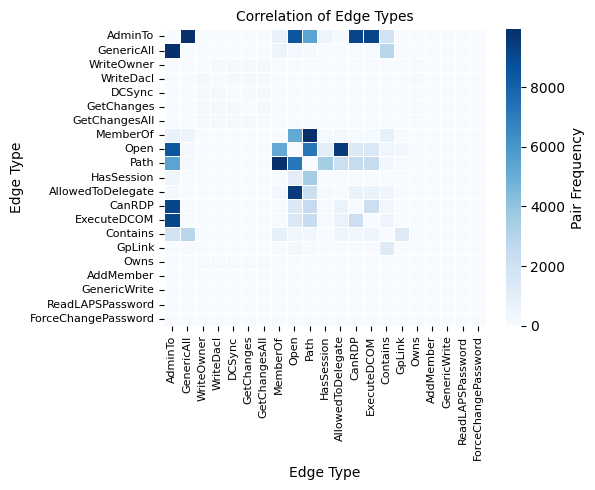

In [251]:
# Correaltion heatmap showing which edges are commonly found parallel

def plot_edge_type_correlation_heatmap(graphs):
    
    """
    Plot a heatmap showing correlation of edge types found together between the same (u, v)
    """
    
    edge_pair_counts = defaultdict(lambda: defaultdict(int))
    
    for G in graphs.values():
        for u, v, data in G.edges(data=True):
            edge_type = data.get("type_", "Unknown")
            edge_pair_counts[(u, v)][edge_type] += 1

    edge_type_corr_matrix = defaultdict(lambda: defaultdict(int))
    for edge_pair, types_count in edge_pair_counts.items():
        types = list(types_count.keys())
        if len(types) > 1:  
            for i in range(len(types)):
                for j in range(i + 1, len(types)):
                    edge_type_corr_matrix[types[i]][types[j]] += 1
                    edge_type_corr_matrix[types[j]][types[i]] += 1  

    edge_types = list(edge_type_corr_matrix.keys())
    
    corr_matrix = np.zeros((len(edge_types), len(edge_types)))
    for i, edge_type_i in enumerate(edge_types):
        for j, edge_type_j in enumerate(edge_types):
            corr_matrix[i, j] = edge_type_corr_matrix[edge_type_i].get(edge_type_j, 0)

    corr_df = pd.DataFrame(corr_matrix, index=edge_types, columns=edge_types)
    corr_df = corr_df.rename(index={"optimal": "Path"}, columns={"optimal": "Path"})  # Rename for clarity if needed

    plt.figure(figsize=(6,5))
    sns.heatmap(corr_df, 
                annot=False, 
                cmap="Blues", 
                linewidths=.5, 
                cbar_kws={'label': 'Pair Frequency'})
    
    plt.title("Correlation of Edge Types", fontsize=10)
    plt.xlabel("Edge Type", fontsize=10)
    plt.ylabel("Edge Type", fontsize=10)
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=8)
    plt.savefig('EDA/edge_type_correlation.jpeg', dpi=400, bbox_inches='tight', transparent=True)
    plt.tight_layout()
    plt.show()

plot_edge_type_correlation_heatmap(graphs)

/tmp/ipykernel_170414/1818013122.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(new_labels, rotation=rotation, fontsize=8)


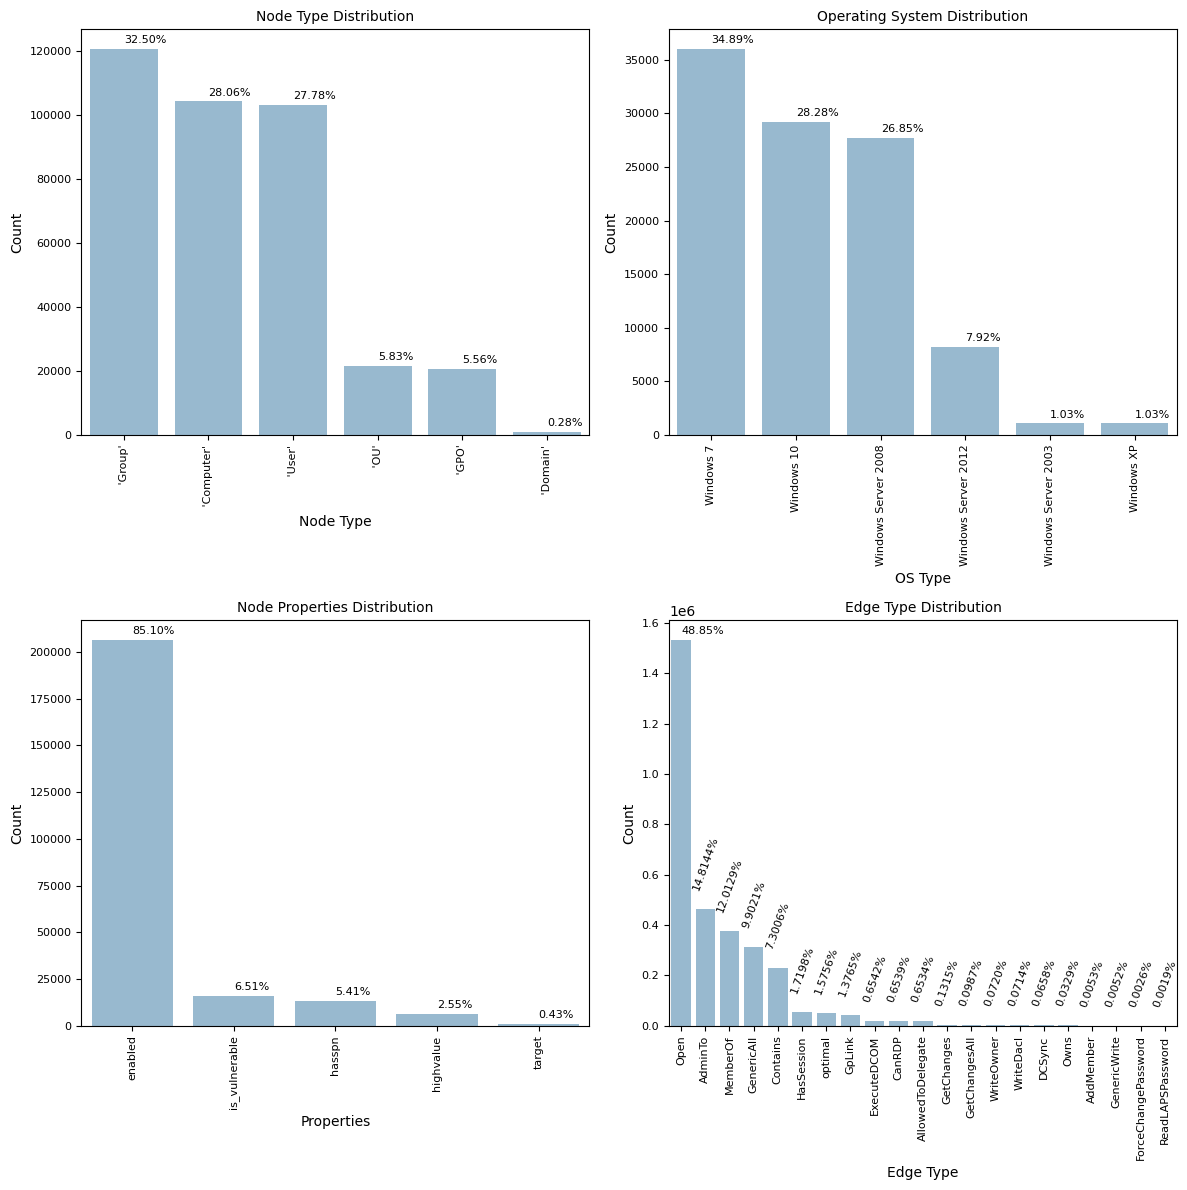

In [249]:
# PLot counts for : OS Types, Node Types, Properties, Edge Type

node_label_counts = Counter()
os_counts = Counter()
property_counts = Counter()
edge_type_counts = Counter()

label_combinations = [['Base', 'Computer'], ['Base', 'OU'], ['Base', 'User'], ['Base', 'Group'], 
                      ['Base', 'GPO'], ['Base', 'Domain']]
operating_systems = ["Windows Server 2003", "Windows Server 2008", "Windows 7", "Windows 10", 
                     "Windows XP", "Windows Server 2012", "Windows Server 2008"]
properties = ["enabled", "hasspn", "highvalue", "is_vulnerable", "target", "owned"]

for G in graphs.values():
    for node, data in G.nodes(data=True):
        for label_combination in label_combinations:
            if all(item in data.get("labels", []) for item in label_combination):
                node_label_counts[str(label_combination)] += 1
        os_value = data.get('properties', {}).get('operatingsystem', None)
        if os_value in operating_systems:
            os_counts[os_value] += 1      
        for prop in properties:
            if data.get('properties', {}).get(prop, False):
                property_counts[prop] += 1
    for _, _, data in G.edges(data=True):
        edge_type = data.get("type_", "Unknown")  
        edge_type_counts[edge_type] += 1


def plot_histograms_in_quadrant_percentage_only(counts_list, titles, xlabels, rotation=90):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    
    for i, (counts, title, xlabel) in enumerate(zip(counts_list, titles, xlabels)):
        total = sum(counts.values())
        
        percentages = {key: (value / total) * 100 for key, value in counts.items()}
        
        sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
        sorted_percentages = {key: percentages[key] for key in sorted_counts}

        sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()), ax=axes[i], alpha=.5)
        
        if i == 0:  
            new_labels = [label.split(',')[-1].strip("[]") for label in sorted_counts.keys()]
            axes[i].set_xticklabels(new_labels, rotation=rotation, fontsize=8)
        
        max_y_value = max(sorted_counts.values())
        
        if i == 3:
            num_bars = len(sorted_counts)
            for j in range(num_bars-20, num_bars):
                percentage = sorted_percentages[list(sorted_counts.keys())[j]]
                x_position = j  # Position of the bar
                
                y_position = sorted_counts[list(sorted_counts.keys())[j]] + max_y_value * 0.05
                
                axes[i].text(x_position, y_position, f'{percentage:.4f}%', ha='center', fontsize=8, rotation=70)

        for idx, (key, count) in enumerate(sorted_counts.items()):
            percentage = sorted_percentages[key]
            
            if i != 3 or (i == 3 and idx < num_bars-20):
                # Calculate annotation offset based on the max y-value
                annotation_offset = max_y_value * 0.015  # 5% of the maximum y-value
                y_position = count + annotation_offset  # Adjust the vertical position of annotations
                axes[i].text(idx, y_position, f'{percentage:.2f}%', ha='left', fontsize=8)

        axes[i].set_xlabel(xlabel, fontsize=10)
        axes[i].set_ylabel("Count", fontsize=10)
        axes[i].set_title(title, fontsize=10)
        axes[i].tick_params(axis="x", rotation=rotation, labelsize=8)
        axes[i].tick_params(axis="y", labelsize=8)
    
    plt.savefig('EDA/quadrant_properties.jpeg', dpi=400, bbox_inches='tight', transparent=True)
    plt.tight_layout()
    plt.show()

counts_list = [node_label_counts, os_counts, property_counts, edge_type_counts]
titles = ["Node Type Distribution", "Operating System Distribution", "Node Properties Distribution", "Edge Type Distribution"]
xlabels = ["Node Type", "OS Type", "Properties", "Edge Type"]
plot_histograms_in_quadrant_percentage_only(counts_list, titles, xlabels)

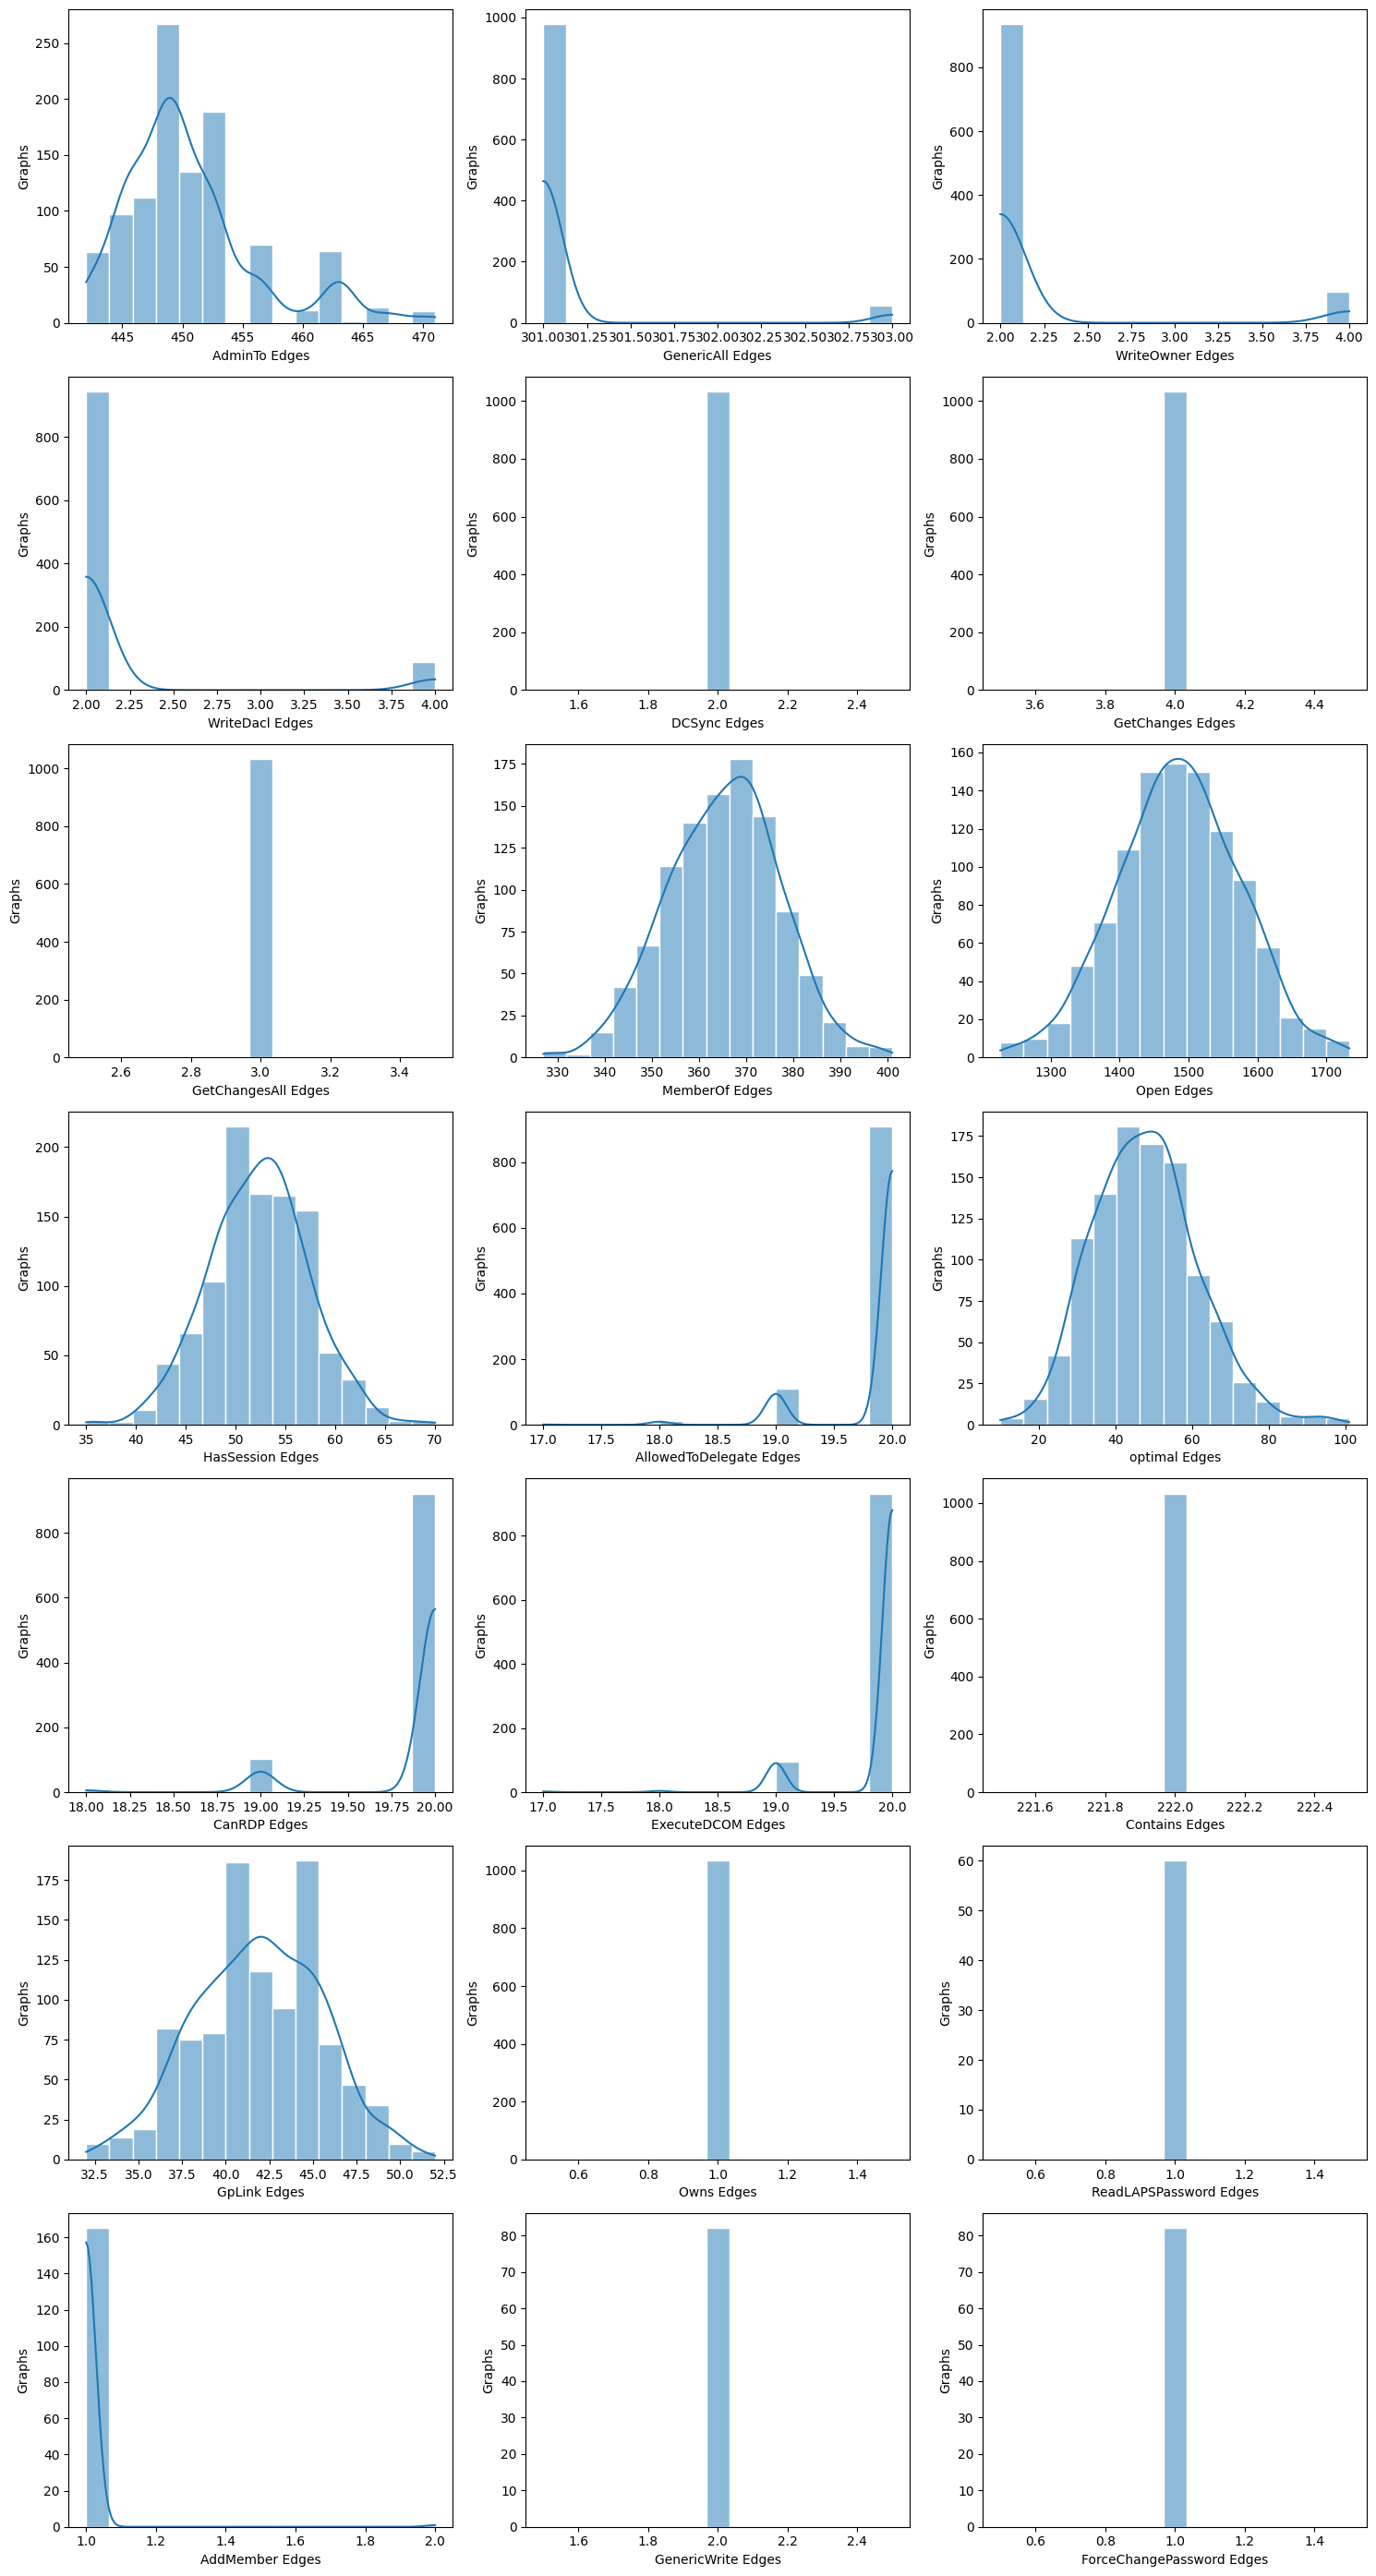

In [252]:
edge_types = ["AdminTo", "AllowedToDelegate", "CanRDP", "Contains", "DCSync", "ExecuteDCOM", 
              "GenericAll", "GetChanges", "GetChangesAll", "GpLink", "HasSession", "MemberOf", 
              "Open", "Owns", "WriteDacl", "WriteOwner"]

edge_type_counts = defaultdict(list)
for graph_name, G in graphs.items():
    edge_count = defaultdict(int)  
    for _, _, data in G.edges(data=True):
        edge_type = data.get("type_", "Unknown")  
        edge_count[edge_type] += 1
    
    for edge_type, count in edge_count.items():
        edge_type_counts[edge_type].append(count)

num_edge_types = len(edge_type_counts)
n_cols = 3
n_rows = (num_edge_types + n_cols - 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()
for idx, (edge_type, counts) in enumerate(edge_type_counts.items()):
    sns.histplot(counts, kde=True, bins=15, ax=axes[idx], alpha=.5, edgecolor='white')
    #axes[idx].set_title(f'{edge_type}')
    axes[idx].set_xlabel(f'{edge_type} Edges')
    axes[idx].set_ylabel("Graphs")

for i in range(num_edge_types, len(axes)):
    axes[i].axis('off')

plt.savefig('EDA/distribution_edge_type.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

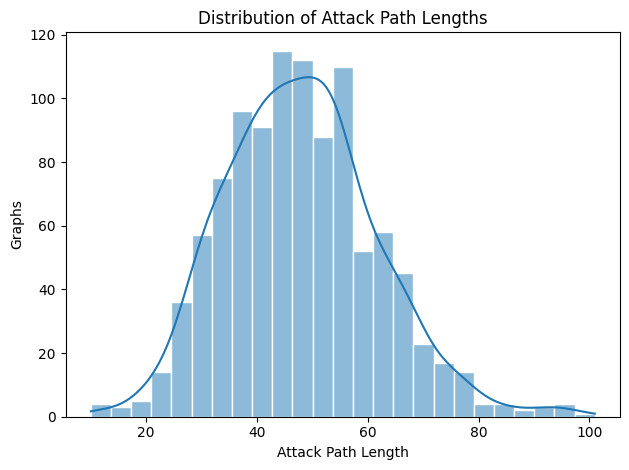

In [254]:
# Plot the attack path lenght distribution

path_lengths = []
for graph_name, G in graphs.items():
    path_edges = [data for _, _, data in G.edges(data=True) if data.get("type_") == "optimal"]
    path_lengths.append(len(path_edges))

sns.histplot(path_lengths, kde=True, bins=25, edgecolor='white',alpha=.5)
plt.title("Distribution of Attack Path Lengths")
plt.xlabel("Attack Path Length")
plt.ylabel("Graphs")
plt.savefig('EDA/path_lenght_distribution.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

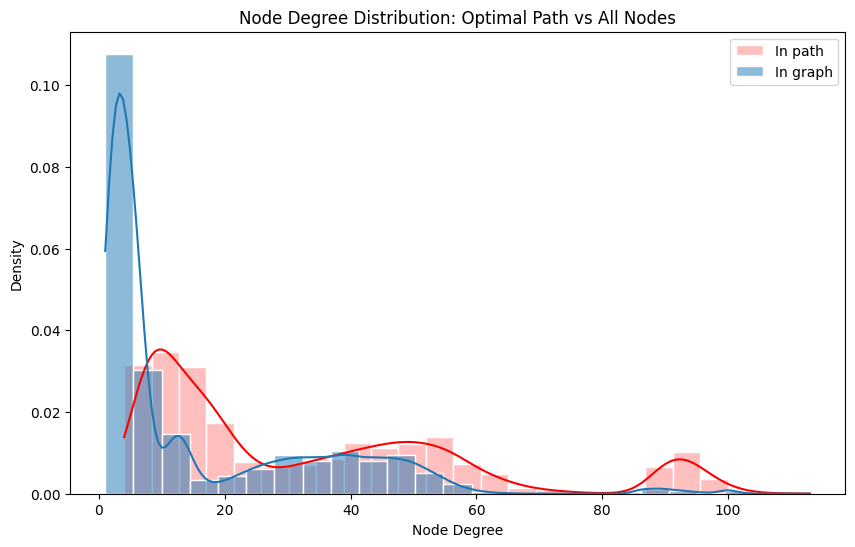

In [255]:
# Compare the degree of nodes in attack path with degree of nodes outside attack path

path_node_degrees = []
all_node_degrees = []

for graph_name, G in graphs.items():
    path_nodes = [u for u, _, data in G.edges(data=True) if data.get("type_") == "optimal"]
    for node in path_nodes:
        path_node_degrees.append(G.degree(node))
    for node in G.nodes():
        all_node_degrees.append(G.degree(node))

path_node_degrees = [degree for degree in path_node_degrees if degree <= 200]
all_node_degrees = [degree for degree in all_node_degrees if degree <= 200]

plt.figure(figsize=(10, 6))
sns.histplot(path_node_degrees, color='red', kde=True, bins=25, label="In path", alpha=0.25, edgecolor="white", stat="density")
sns.histplot(all_node_degrees, kde=True, label="In graph", bins=25, alpha=0.5, edgecolor="white", stat="density")
plt.title("Node Degree Distribution: Optimal Path vs All Nodes")
plt.xlabel("Node Degree")
plt.ylabel("Density")
plt.savefig('EDA/path_degree_vs_graph_degree_distribution.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.legend()
plt.show()

In [103]:
#path = '/media/marin/DATA/PhD/GNN-PINN-End2End/Databases/BloodHound-Tools/autobloody/GraphDataset/OwnedSet/graph_VrxXUZQ1.pickle'
#graph_files = glob.glob(os.path.join(path, 'graph_*.pickle'))
#graphs = {}

#with open(path, "rb") as f:
#    G = pickle.load(f)

In [105]:
# Define the directory containing graph files
directory = "/media/marin/DATA/PhD/GNN-PINN-End2End/Databases/BloodHound-Tools/autobloody/GraphDataset/OwnedSetBig/"

# Find all pickle files matching the pattern "graph_*.pickle"
graph_files = glob.glob(os.path.join(directory, "graph_*.pickle"))

# Load all graphs into a dictionary
graphs = {}
for file in graph_files:
    with open(file, "rb") as f:
        G = pickle.load(f)
        if isinstance(G, nx.Graph):  # Ensure it's a valid NetworkX graph
            graphs[file] = G
        else:
            print(f"Warning: {file} is not a valid NetworkX graph.")

print(f"Loaded {len(graphs)} graphs successfully!")

Loaded 1033 graphs successfully!


In [106]:
# Initialize counters
total_nodes = 0
total_edges = 0
graph_sizes = []

for filename, G in graphs.items():
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    total_nodes += num_nodes
    total_edges += num_edges
    graph_sizes.append((filename, num_nodes, num_edges))

# Print dataset-level stats
print(f"Total Graphs: {len(graphs)}")
print(f"Total Nodes Across All Graphs: {total_nodes}")
print(f"Total Edges Across All Graphs: {total_edges}")

# Find the smallest and largest graphs
smallest_graph = min(graph_sizes, key=lambda x: x[1])  # by number of nodes
largest_graph = max(graph_sizes, key=lambda x: x[1])  # by number of nodes

print(f"Smallest Graph: {smallest_graph[0]} ({smallest_graph[1]} nodes, {smallest_graph[2]} edges)")
print(f"Largest Graph: {largest_graph[0]} ({largest_graph[1]} nodes, {largest_graph[2]} edges)")

Total Graphs: 1033
Total Nodes Across All Graphs: 372913
Total Edges Across All Graphs: 3141174
Smallest Graph: /media/marin/DATA/PhD/GNN-PINN-End2End/Databases/BloodHound-Tools/autobloody/GraphDataset/OwnedSetBig/graph_jV3LdG20.pickle (361 nodes, 3083 edges)
Largest Graph: /media/marin/DATA/PhD/GNN-PINN-End2End/Databases/BloodHound-Tools/autobloody/GraphDataset/OwnedSetBig/graph_jV3LdG20.pickle (361 nodes, 3083 edges)


## archive

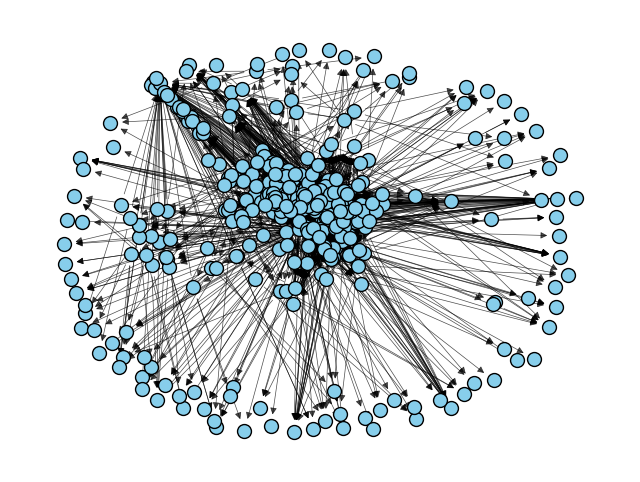

In [12]:
def plot_graph(G, node_size=100, edge_width=.5, node_color='skyblue', with_labels=False):
    """
    Plots a NetworkX graph with a clean layout.

    Args:
        G (networkx.Graph): The graph to be plotted.
        node_size (int): Size of the nodes.
        edge_width (float): Thickness of the edges.
        node_color (str or list): Color of the nodes (single color or per-node list).
        with_labels (bool): Whether to display node labels.
    """
    plt.figure(figsize=(8, 6))  # Set figure size

    # Position nodes using a force-directed layout
    pos = nx.spring_layout(G, seed=42)  

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, edgecolors='black')

    # Draw edges (with optional width scaling based on weights)
    if nx.get_edge_attributes(G, 'weight'):
        weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, width=[edge_width * w for w in weights], alpha=0.7)
    else:
        nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.7)

    # Draw labels (optional)
    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    plt.axis("off")  # Hide axes
    plt.show()


# Example: Create & Plot a Graph
plot_graph(G)

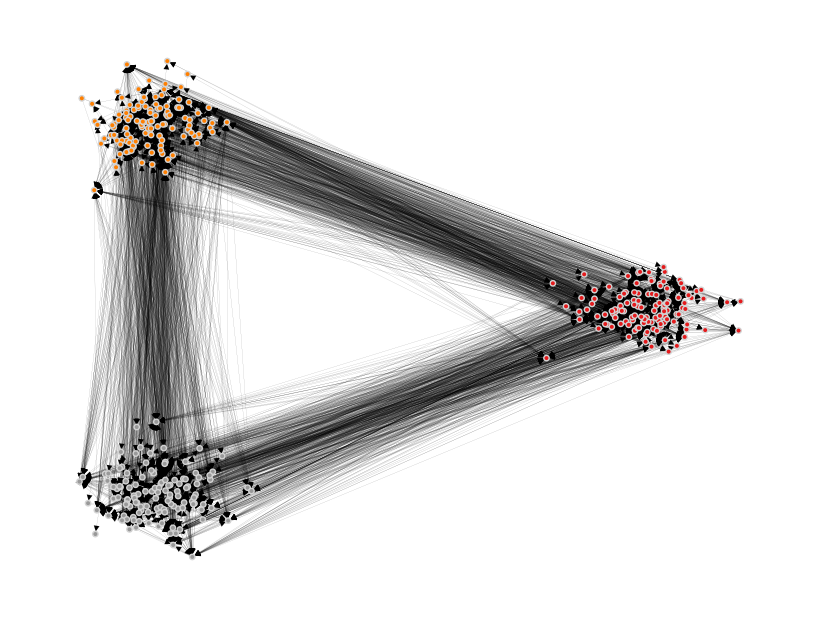

In [44]:
def cluster_layout(G, label_attr="labels", scale=2, spread=0.2):
    """
    Creates a layout where nodes are clustered based on their label attribute.
    
    Args:
        G (networkx.Graph): The graph.
        label_attr (str): Node attribute to define clusters.
        scale (float): Distance between clusters.
        spread (float): Spread of nodes within a cluster.

    Returns:
        dict: Positions of nodes.
    """
    # Group nodes by label
    clusters = {}
    for node, data in G.nodes(data=True):
        label = data.get(label_attr, "default")  # Default if missing
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(node)

    # Define cluster positions in a circular layout
    cluster_positions = {}
    angle_step = 2 * np.pi / len(clusters)  # Evenly distribute clusters in a circle
    for i, (label, nodes) in enumerate(clusters.items()):
        angle = i * angle_step  
        center = np.array([np.cos(angle), np.sin(angle)]) * scale  # Spread clusters out

        for node in nodes:
            offset = np.random.normal(scale=spread, size=2)  # Small random offset
            cluster_positions[node] = center + offset

    return cluster_positions

for i, node in enumerate(G.nodes()):
    G.nodes[node]["labels"] = i % 7 # Create 3 clusters

# Get clustered layout
pos = cluster_layout(G, label_attr="labels")

# Draw the graph with cluster-based positioning
plt.figure(figsize=(8, 6))
nx.draw(G, pos, 
        node_color=[G.nodes[n]['labels'] for n in G.nodes()], 
        cmap=plt.cm.Set1, 
        node_size=15, 
        edgecolors="lightgrey", 
        width=.05,
        with_labels=False)

plt.show()

In [107]:
import torch
from matplotlib import pyplot as plt

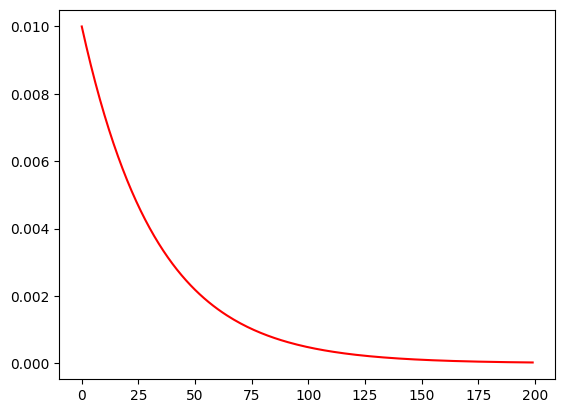

In [109]:
lr_list = []
lr_2 = []

model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
LR = 0.01
optimizer = torch.optim.Adam(model, lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
for epoch in range(0,200):
    data_size = 400
    # when epoch = 0
    for i in range(data_size):
        optimizer.zero_grad()
        #loss
        optimizer.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
    scheduler.step() # update lr with gamma
#print(lr_list)
plt.plot(range(len(lr_list)),lr_list,color = 'r')
plt.show()

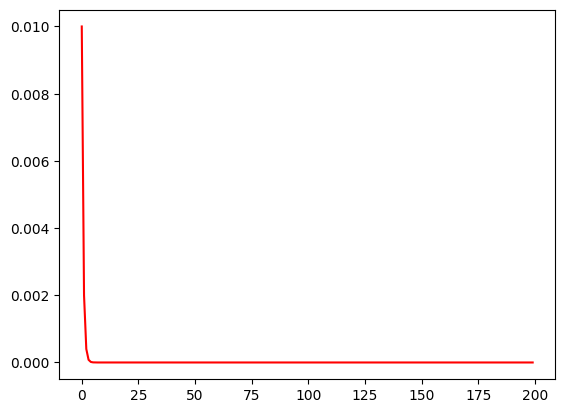

In [110]:
lr_list = []
lr_2 = []

model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
LR = 0.01
optimizer = torch.optim.Adam(model, lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.2)
for epoch in range(0,200):
    data_size = 400
    # when epoch = 0
    for i in range(data_size):
        optimizer.zero_grad()
        #loss
        optimizer.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
    scheduler.step() # update lr with gamma
#print(lr_list)
plt.plot(range(len(lr_list)),lr_list,color = 'r')
plt.show()

In [ ]:
#
# Corrected cycle loss (previous only penalised self-loops)
#

def corrected_cycle_loss(B, K=10):
    """
    Penalizes any cycles in the predicted adjacency matrix B by computing B^K.

    Args:
        B (torch.Tensor): Adjacency matrix of shape (B, N, N).
        K (int, optional): Power of the adjacency matrix to compute. If None, defaults to the number of nodes.

    Returns:
        torch.Tensor: Cycle loss value.
    """
    batch_size, num_nodes, _ = B.shape
    if K is None:
        K = num_nodes  # Set K to the number of nodes if not provided

    B_power = B.clone()  # Start with B^1

    for _ in range(1, K):  # Compute B^K
        B_power = torch.bmm(B_power, B)

    cycle_penalty = torch.diagonal(B_power, dim1=-2, dim2=-1).sum(dim=-1)  # Extract diagonal

    return cycle_penalty.mean()

In [2]:
import pandas as pd

In [10]:
data = pd.read_csv('Exports/back_warmup_training_log.csv')
data.head()

,Epoch,Batch,Loss
0,1,52,410.632904
1,2,52,367.169342
2,3,52,369.937531
3,4,52,371.429321
4,5,52,367.508484


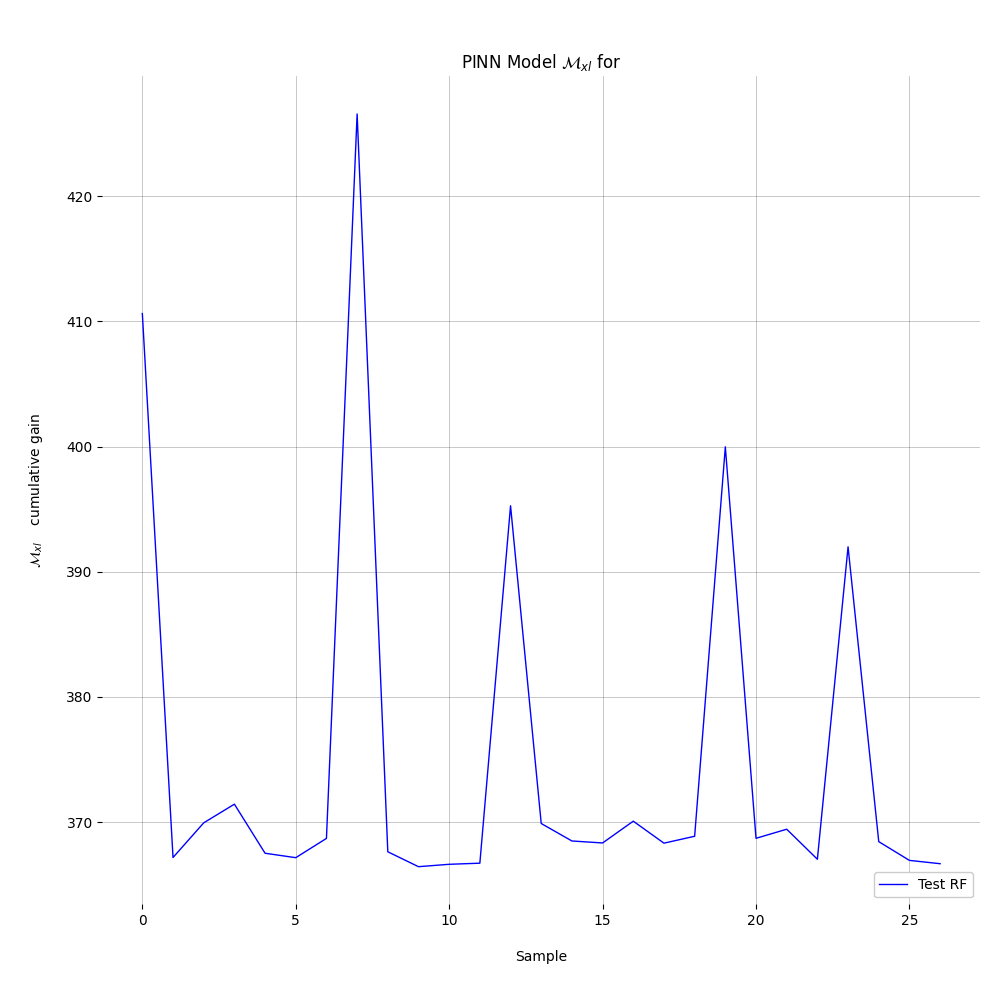

In [13]:
plt.figure(figsize=(10,10))

plt.plot(data['Loss'][:27], color="blue", label="Test RF", linewidth=1)
#plt.plot(rf_gain_curve_train[:100], color="blue", label="Train RF",  linewidth=1, linestyle='--')

#plt.plot(dnn_gain_curve_test[:100], color="red", label="Test DNN", linewidth=1)
#plt.plot(dnn_gain_curve_train[:100], color="red", label="Train DNN",  linewidth=1, linestyle='--')

#plt.plot([0, 100], [0, elast(test, "Y", T)], linewidth=1, linestyle="dotted", color="black", label="Baseline")

plt.legend(loc='lower right', fontsize=10, frameon=True, framealpha=1)
plt.title(f"\n\nPINN Model"+r' $\mathcal{M}_{xl}$ for ', fontsize=12)
plt.ylabel("\n"+r'$\mathcal{M}_{xl}$'+"    cumulative gain \n", fontsize=10)
plt.xlabel("\nSample\n", fontsize=10)

#textstr = r'$\bar{ATE}$ : '+f'{ATE:.4f}'
#props = dict(boxstyle='round', facecolor='wheat', alpha=1)
#plt.gca().text(0.1, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
#        verticalalignment='top', bbox=props)

plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
plt.draw()
plt.box(False)

#plt.savefig('Figures/FIG6_XLEARN_X17_ATE_RF_DNN.jpeg', dpi=400, bbox_inches='tight', transparent=True)

plt.tight_layout()
plt.show()